# Howework 3



For the final howmeowrk assigment, my goal is to build a discrete even simulation (des) model.  The process I have chosen to analyze is the process of opening a bank account.

## Preliminaries

In [1]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

Import commonly used libraries and magic command for inline plotting

In [2]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import expon
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

from scipy.stats import expon


In [3]:
%matplotlib inline

## Work

This is where work gets done.

In [4]:
# Simple clock

def simple_clock(tick_size):
    t = 0
    while True:
        print(f"The time was {t} and you asked me to tick {tick_size} time units.")
        t += tick_size
        yield t

In [5]:
clock = simple_clock(5)
print(next(clock))
print(next(clock))
print(next(clock))

The time was 0 and you asked me to tick 5 time units.
5
The time was 5 and you asked me to tick 5 time units.
10
The time was 10 and you asked me to tick 5 time units.
15


In [6]:
# Random number generator
rg = default_rng(seed=4470)
print(rg.random())
print(rg.random())

0.45855804438027437
0.15021752731855942


In [16]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts the patient_arrivals process and adds it to the environment
runtime = 25
interarrival_time = 3.0
env1.process(customer_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

NameError: name 'customer_arrivals' is not defined

In [44]:
# Import exponential distribution function from scipy.stats
#from scipy.stats import expon
# Set mean of this distribution to whatever we were using above for interarrival time
mean_interarrival_time = interarrival_time
# Create a random variable object based on the exponential distribution with the given mean
rv_expon = expon(scale=mean_interarrival_time)

In [104]:
class Bank(object):
    def __init__(self, env, num_greeters, num_bankers, rg):
        # Simulation environment
        self.env = env
        self.rg = rg
        
        # Create list to hold timestamps dictionaries (one per patient)
        self.timestamps_list = []
       
        # Create lists to hold occupancy tuples (time, occ)
        self.cust_waiting_list = [(0.0, 0.0)]
        self.cust_beinghelped_list = [(0.0, 0.0)]
        
        # Create resources
        self.greeter = simpy.Resource(env, num_greeters)
        self.banker = simpy.Resource(env, num_bankers)
        #self.vaccinator = simpy.Resource(env, num_vaccinators)
        #self.scheduler = simpy.Resource(env, num_schedulers)

    # Create process methods - hard coding processing time distributions for now
    # TODO - remove hard coding
    # The patient argument is just a unique integer number
    def sign_in(self, customer):
        yield self.env.timeout(self.rg.normal(0.25, 0.05))

    def wait_for_banker(self, customer):
        yield self.env.timeout(self.rg.exponential(.3))
        
    def open_account(self, customer):
        yield self.env.timeout(self.rg.exponential(2.0))
    
    # We assume all patients wait at least 15 minutes post-vaccination
    # Some will choose to wait longer. This is the time beyond 15 minutes
    # that patients wait.
    #def wait_gt_15(self, patient):
        #yield self.env.timeout(self.rg.exponential(0.5))
        
     #   print(f"Customer {customer} created at time {env.now}")

In [105]:
def open_account(env, customer, bank, rg):
    # Patient arrives to clinic - note the arrival time
    arrival_ts = env.now

    # Request a greeter to direct customer to wait for banker
    # By using request() in a context manager, we'll automatically release the resource when done
    with bank.greeter.request() as request:
        yield request
        # Now that we have a greeter, check temperature. Note time.
        got_greeter_ts = env.now
        yield env.process(bank.sign_in(customer))
        release_greeter_ts = env.now

    bank.cust_waiting_list.append((env.now, bank.cust_waiting_list[-1][1] + 1))

    # Wait at least 15 minutes from time we finished getting vaccinated  - wait for banker
    wait_time = env.now - release_greeter_ts
    if wait_time < 15:
        # Wait until 15 total minutes post vac
        yield env.timeout(15 - wait_time)
        # Wait random amount beyond 15 minutes
        yield env.process(bank.wait_for_banker(customer))
        release_wait_time = env.now


        # Update postvac occupancy - decrement by 1
   

        bank.cust_waiting_list.append((env.now, bank.cust_waiting_list[-1][1] - 1))

        bank.cust_beinghelped_list.append((env.now, bank.cust_beinghelped_list[-1][1] + 1))


    # Request banker to help customer complete application
  #  with bank.banker.request() as request:
  #      yield request
  #      got_open_account_ts = env.now
  #      yield env.process(bank.open_account(customer))
  #      release_open_account_ts = env.now

    with bank.banker.request() as request:
        yield request
        got_banker_ts = env.now
        # Update banker occupancy - increment by 1
        pre_cust = bank.cust_beinghelped_list[-1][1]
        new_cust = (env.now, pre_cust + 1)
        bank.cust_beinghelped_list.append(new_cust)
        yield env.process(bank.open_account(customer))
        release_banker_ts = env.now

        bank.cust_beinghelped_list.append((env.now, bank.cust_beinghelped_list[-1][1] - 1))

    # Request reg staff to get registered
    #with clinic.reg_staff.request() as request:
     #   yield request
      #  got_reg_ts = env.now
       # yield env.process(bank.registration(patient))
        #release_reg_ts = env.now
        
    # Request banker to help customer
   # with clinic.vaccinator.request() as request:
    #    yield request
     #   got_banker_ts = env.now
        # Update vac occupancy - increment by 1
    #    prev_occ = clinic.vac_occupancy_list[-1][1]
     #   new_occ = (env.now, prev_occ + 1)
      #  bank.cust_beinghelped_list.append(new_occ)
     #   yield env.process(clinic.vaccinate(customer))
      #  release_vaccinator_ts = env.now


        # Update vac occupancy - decrement by 1 - more compact code
        # Note that clinic.vac_occupancy_list[-1] is the last tuple in the list
        #  and that clinic.vac_occupancy_list[-1][1] is referencing the occupancy
        #  value in the tuple (remember tuple elements are indexed starting with 0, so
        #  the timestamp is at [0] and the occupancy is at [1]).
        #  BTW, this suggests that perhaps using something known as "namedtuples" might
        #  make our code more readable. See https://realpython.com/python-namedtuple/ 
        #  for a good introduction to namedtuples.
       # bank.cust_waiting_list.append((env.now, bank.cust_waiting_list[-1][1] - 1))
        
        # Update postvac occupancy - increment by 1
       # bank.cust_beinghelped_list.append((env.now, bank.cust_beinghelped_list[-1][1] + 1))

    # Request scheduler to schedule second dose if needed
    #if rg.random() < pct_first_dose:
     #   with clinic.scheduler.request() as request:
      #      yield request
       #     got_scheduler_ts = env.now
        #    yield env.process(clinic.schedule_dose_2(patient))
         #   release_scheduler_ts = env.now
    #else:
     #   got_scheduler_ts = pd.NA
      #  release_scheduler_ts = pd.NA
        
    # Wait at least 15 minutes from time we finished getting vaccinated  - wait for banker
   # wait_for_banker = env.now - release_banker_ts
   # if wait_time < 15:
        # Wait until 15 total minutes post vac
   #     yield env.timeout(15 - wait_time)
        # Wait random amount beyond 15 minutes
   #     yield env.process(clinic.cust_waiting_list(customer))
   #     exit_system_ts = env.now
        
        # Update postvac occupancy - decrement by 1
       # bank.cust_waiting_list.append((env.now, cust_waiting_list[-1][1] - 1))
    
    exit_system_ts = env.now    
    #print(f"Patient {patient} exited at time {env.now}")

    # Create dictionary of timestamps
    timestamps = {'customer_id': customer,
                  'arrival_ts': arrival_ts,
                  'got_greeter_ts': got_greeter_ts,
                  'release_greeter_ts': release_greeter_ts,
                  'wait_time': wait_time,
                  'release_wait_time': release_wait_time,
                  'got_banker_ts': got_banker_ts,
                  'release_banker_ts': release_banker_ts,
                  'exit_system_ts': exit_system_ts}
    
    bank.timestamps_list.append(timestamps)

In [106]:
# Running bank for specific hours

def run_bank(env, bank, mean_interarrival_time, rg, 
               stoptime=simpy.core.Infinity, max_arrivals=simpy.core.Infinity):
      
    # Create a counter to keep track of number of patients generated and to serve as unique patient id
    customer = 0

    # Loop for generating patients
    while env.now < stoptime and customer < max_arrivals:

        # Generate next interarrival time (this will be more complicated later)
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New patient generated = update counter of patients
        customer += 1
        
        #print(f"Patient {patient} created at time {env.now}")

        env.process(open_account(env, customer, bank, rg))


In [113]:
def main():
    
    # For now we are hard coding the patient arrival rate (patients per hour)
    customers_per_hour = 4
    mean_interarrival_time = 1.0 / (customers_per_hour / 60.0)
  #  pct_first_dose = 0.50
    
    # Create a random number generator
    rg = default_rng(seed=4470)
    
    # For now we are going to hard code in the resource capacity levels 
    num_greeters = 1
    num_bankers = 5
    
    # Hours of operation
    stoptime = 480 # No more arrivals after this time
    
    # Create a simulation environment
    env = simpy.Environment()
    # Create a clinic to simulate
    bank = Bank(env, num_greeters, num_bankers, rg)
    
    # Register the run_clinic (generator) function
    env.process(run_bank(env, bank, mean_interarrival_time, rg, stoptime=stoptime))
    # Actually run the simulation
    env.run()
    
    # The simulation is over now, let's create the output csv files from 
    # the dataframes created by running the simulation model.
    
    # Output log files 
    bank_customer_log_df = pd.DataFrame(bank.timestamps_list)
    bank_customer_log_df.to_csv('./output/bank_customer_log_df.csv', index=False)
    
    cust_waiting_df = pd.DataFrame(bank.cust_waiting_list, columns=['ts', 'occ'])
    cust_waiting_df.to_csv('./output/cust_waiting_df.csv', index=False)    
    
    cust_beinghelped_df = pd.DataFrame(bank.cust_beinghelped_list, columns=['ts', 'occ'])
    cust_beinghelped_df.to_csv('./output/cust_beinghelped_df.csv', index=False)
    

    # Note simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)


In [114]:
bank_end_time = main()

Simulation ended at time 523.6465163792469


In [115]:
bank_customer_log_df = pd.read_csv('./output/bank_customer_log_df.csv')
bank_customer_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         33 non-null     int64  
 1   arrival_ts          33 non-null     float64
 2   got_greeter_ts      33 non-null     float64
 3   release_greeter_ts  33 non-null     float64
 4   wait_time           33 non-null     float64
 5   release_wait_time   33 non-null     float64
 6   got_banker_ts       33 non-null     float64
 7   release_banker_ts   33 non-null     float64
 8   exit_system_ts      33 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 2.4 KB


In [116]:
bank_customer_log_df.head()

,customer_id,arrival_ts,got_greeter_ts,release_greeter_ts,wait_time,release_wait_time,got_banker_ts,release_banker_ts,exit_system_ts
0,2,12.976768,12.976768,13.254339,0.0,28.304767,28.304767,28.385382,28.385382
1,1,11.662377,11.662377,11.837842,0.0,27.049301,27.049301,28.885719,28.885719
2,3,18.462901,18.462901,18.807007,0.0,34.014628,34.014628,34.154360,34.154360
3,4,32.296987,32.296987,32.532792,0.0,47.573481,47.573481,48.074707,48.074707
4,5,60.443282,60.443282,60.647596,0.0,75.930376,75.930376,77.049716,77.049716


In [117]:
def compute_durations(timestamp_df):
    
    timestamp_df['wait_for_greeter'] = timestamp_df.loc[:, 'got_greeter_ts'] - timestamp_df.loc[:, 'arrival_ts']
    timestamp_df['waiting_for_banker_time'] = timestamp_df.loc[:, 'release_wait_time'] - timestamp_df.loc[:, 'wait_time']
    timestamp_df['open_account_time'] = timestamp_df.loc[:, 'release_banker_ts'] - timestamp_df.loc[:, 'got_banker_ts']
    timestamp_df['time_in_system'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'arrival_ts']
    
    return timestamp_df

In [118]:
bank_customer_log_df = compute_durations(bank_customer_log_df)
bank_customer_log_df

,customer_id,arrival_ts,got_greeter_ts,release_greeter_ts,wait_time,release_wait_time,got_banker_ts,release_banker_ts,exit_system_ts,wait_for_greeter,waiting_for_banker_time,open_account_time,time_in_system
0,2,12.976768,12.976768,13.254339,0.0,28.304767,28.304767,28.385382,28.385382,0.000000,28.304767,0.080615,15.408614
1,1,11.662377,11.662377,11.837842,0.0,27.049301,27.049301,28.885719,28.885719,0.000000,27.049301,1.836418,17.223341
2,3,18.462901,18.462901,18.807007,0.0,34.014628,34.014628,34.154360,34.154360,0.000000,34.014628,0.139732,15.691459
3,4,32.296987,32.296987,32.532792,0.0,47.573481,47.573481,48.074707,48.074707,0.000000,47.573481,0.501226,15.777720
4,5,60.443282,60.443282,60.647596,0.0,75.930376,75.930376,77.049716,77.049716,0.000000,75.930376,1.119340,16.606433
5,6,84.574873,84.574873,84.885865,0.0,99.968380,99.968380,100.104523,100.104523,0.000000,99.968380,0.136143,15.529650
6,7,93.609748,93.609748,93.882707,0.0,109.012480,109.012480,110.467431,110.467431,0.000000,109.012480,1.454951,16.857684
7,8,133.227974,133.227974,133.517088,0.0,148.587658,148.587658,152.662892,152.662892,0.000000,148.587658,4.075235,19.434919
8,9,151.651099,151.651099,151.830739,0.0,167.310248,167.310248,167.587457,167.587457,0.000000,167.310248,0.277209,15.936359
9,10,169.147750,169.147750,169.328541,0.0,184.398872,184.398872,185.557612,185.557612,0.000000,184.398872,1.158740,16.409861


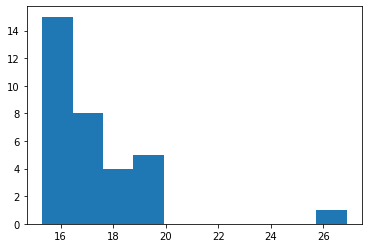

In [119]:
plt.hist(bank_customer_log_df['time_in_system']);

In [ ]:
bank_customer_log_df.loc[:, ['wait_for_greeter', 'wait_for_reg',
                              'wait_for_scheduler', 'wait_for_vaccinator', 'time_in_system']].describe()